In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sb
from time import time
import missingno as msno
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

### Attribute Information
* gender: Gender of self
* age: Age of self
* age_o: Age of partner
* d_age: Difference in age
* race: Race of self
* race_o: Race of partner
* samerace: Whether the two persons have the same race or not.
* importancesamerace: How important is it that partner is of same race?
* importancesamereligion: How important is it that partner has same religion?
* field: Field of study
* prefoattractive: How important does partner rate attractiveness
* prefosinsere: How important does partner rate sincerity
* prefointelligence: How important does partner rate intelligence
* prefofunny: How important does partner rate being funny
* prefoambitious: How important does partner rate ambition
* prefoshared_interests: How important does partner rate having shared interests
* attractive_o: Rating by partner (about me) at night of event on attractiveness
* sincere_o: Rating by partner (about me) at night of event on sincerity
* intelligence_o: Rating by partner (about me) at night of event on intelligence
* funny_o: Rating by partner (about me) at night of event on being funny
* ambitous_o: Rating by partner (about me) at night of event on being ambitious
* sharedinterestso: Rating by partner (about me) at night of event on shared interest
* attractive_important: What do you look for in a partner - attractiveness
* sincere_important: What do you look for in a partner - sincerity
* intellicence_important: What do you look for in a partner - intelligence
* funny_important: What do you look for in a partner - being funny
* ambtition_important: What do you look for in a partner - ambition
* sharedinterestsimportant: What do you look for in a partner - shared interests
* attractive: Rate yourself - attractiveness
* sincere: Rate yourself - sincerity
* intelligence: Rate yourself - intelligence
* funny: Rate yourself - being funny
* ambition: Rate yourself - ambition
* attractive_partner: Rate your partner - attractiveness
* sincere_partner: Rate your partner - sincerity
* intelligence_partner: Rate your partner - intelligence
* funny_partner: Rate your partner - being funny
* ambition_partner: Rate your partner - ambition
* sharedinterestspartner: Rate your partner - shared interests
* sports: Your own interests [1-10]
* tvsports
* exercise
* dining
* museums
* art
* hiking
* gaming
* clubbing
* reading
* tv
* theater
* movies
* concerts
* music
* shopping
* yoga
* interests_correlate: Correlation between participant’s and partner’s ratings of interests.
* expectedhappywithsdpeople: How happy do you expect to be with the people you meet during the speed-dating event?
* expectednuminterestedinme: Out of the 20 people you will meet, how many do you expect will be interested in dating you?
* expectednummatches: How many matches do you expect to get?
* like: Did you like your partner?
* guessprobliked: How likely do you think it is that your partner likes you?
* met: Have you met your partner before?
* decision: Decision at night of event.
* decision_o: Decision of partner at night of event.
* match: Match (yes/no)

In [6]:
data=pd.read_csv("Speed Dating Data.csv")
df = data.drop(["id", "iid"], axis = 1)

In [7]:
data["num_in_3"].value_counts()

1.0    430
0.0    159
2.0     61
4.0     18
Name: num_in_3, dtype: int64

In [8]:
#df.columns.values

In [9]:
#data["prob"].value_counts()

#### Imbalenced dataset

In [11]:
print(100*df['match'].value_counts() / df.shape[0])# 16.47% of the transactions are labeled as matching (imbalanced dataset)

0    83.528288
1    16.471712
Name: match, dtype: float64


## Feature Selection with Correlation

In [12]:
df_corr = df.corr().dropna()

In [13]:
subset_index = df_corr["match"].abs().sort_values(ascending = False)[:20].index.tolist() + ["income"]

In [14]:
print(subset_index)

['match', 'dec_o', 'dec', 'like_o', 'like', 'fun_o', 'fun', 'shar_o', 'shar', 'attr_o', 'attr', 'prob_o', 'prob', 'them_cal', 'intel', 'intel_o', 'sinc_o', 'sinc', 'num_in_3', 'amb', 'income']


In [15]:
df_subset = df[subset_index]
df_subset_corr = df_subset.corr()

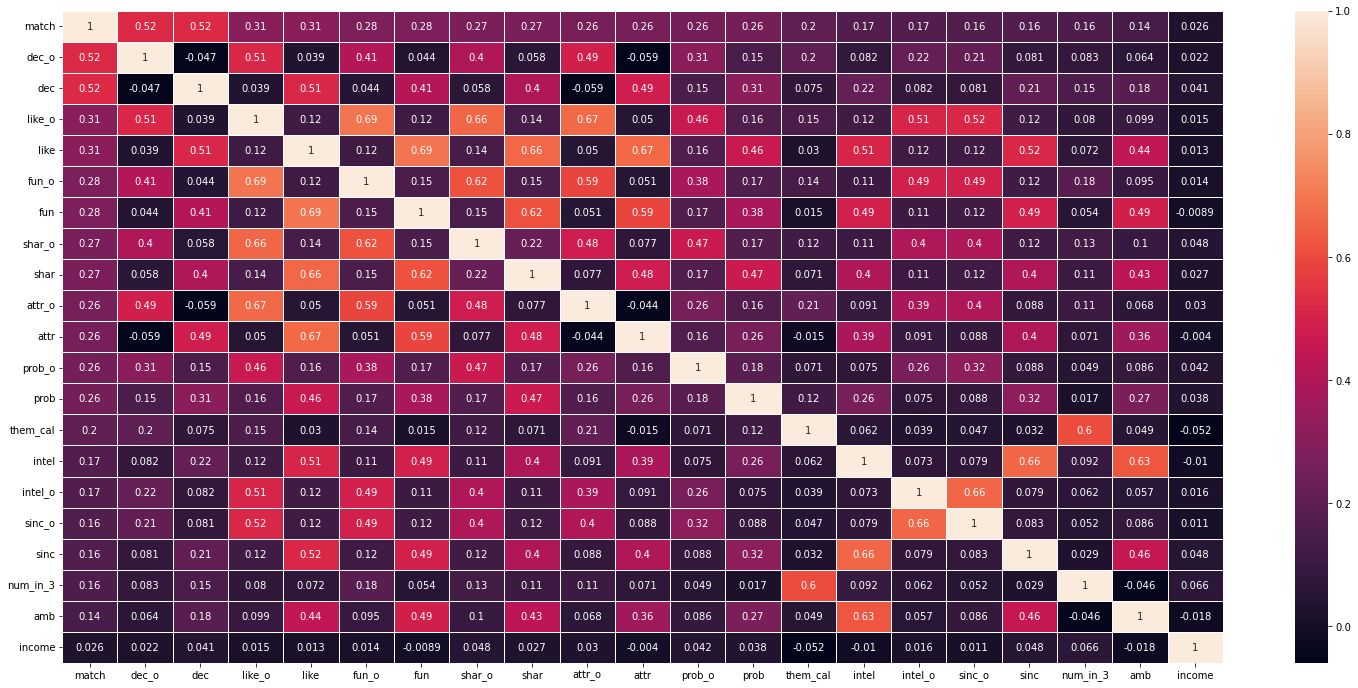

In [16]:
fig, ax = plt.subplots(figsize=(26,12))
sb.heatmap(df_subset_corr, linewidths=.5, annot=True, ax = ax)
plt.show()

## Missing Value

In [17]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

In [18]:
missing_var=[]
for i in subset_index:
    if df_subset[i].isnull().sum()>0:
        missing_var.append(i)
        
print(missing_var)

['like_o', 'like', 'fun_o', 'fun', 'shar_o', 'shar', 'attr_o', 'attr', 'prob_o', 'prob', 'them_cal', 'intel', 'intel_o', 'sinc_o', 'sinc', 'num_in_3', 'amb', 'income']


In [19]:
impute_it = IterativeImputer()
impute_data = impute_it.fit_transform(df_subset[missing_var])
df_subset[missing_var] = impute_data

##  Outlier Detection

In [20]:
#Outlier Detection
from sklearn.ensemble import IsolationForest

#### Isolation Forest Algorithm.

Return the anomaly score of each sample using the IsolationForest algorithm

The IsolationForest 'isolates' observations by randomly selecting a feature
and then randomly selecting a split value between the maximum and minimum
values of the selected feature.

Since recursive partitioning can be represented by a tree structure, the
number of splittings required to isolate a sample is equivalent to the path
length from the root node to the terminating node.

This path length, averaged over a forest of such random trees, is a
measure of normality and our decision function.

Random partitioning produces noticeably shorter paths for anomalies.
Hence, when a forest of random trees collectively produce shorter path
lengths for particular samples, they are highly likely to be anomalies.

In [21]:
ifd = IsolationForest(n_estimators=50, warm_start=True)
ifd.fit(df_subset)  

print(df_subset.shape)

df_subset = df_subset[ifd.predict(df_subset) == 1]

print(df_subset.shape)

(8378, 21)
(6882, 21)


## Data Normalization

In [22]:
#Normalization
from sklearn.preprocessing import MinMaxScaler , StandardScaler

In [23]:
X = df_subset.drop(['match'], axis = 1)
y = df_subset['match'].reset_index(drop = True)

print(X.shape, y.shape)

(6882, 20) (6882,)


In [24]:
min_max_scaler = MinMaxScaler()
X = min_max_scaler.fit_transform(X,y)

## Model Selection and Train

In [25]:
#Model Selection
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from xgboost import XGBClassifier


In [26]:
###Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 13)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(5505, 20) (1377, 20) (5505,) (1377,)


## Train Models

In [27]:
models = {
    "MLP Classifier":MLPClassifier(), 
    "KNeighbors Classifier":KNeighborsClassifier(), 
    "DecisionTree Classifier":DecisionTreeClassifier(),
    "RandomForest Classifier":RandomForestClassifier(), 
    "AdaBoost Classifier":AdaBoostClassifier(), 
    "XGB Classifier":XGBClassifier()
}

In [28]:
param_grids = [
    {'hidden_layer_sizes': [(100),(100,100),(150,150)], 'activation': ('tanh', 'relu'), 'learning_rate_init':[0.001, 0.002, 0.005], 'max_iter':[200,500,1000]},
    {'n_neighbors': [5,15,25,50], 'weights': ('uniform', 'distance'), 'algorithm':('auto', 'ball_tree', 'kd_tree')},
    {'criterion':('gini', 'entropy', 'log_loss'), 'min_samples_split':[2,5,10], 'min_samples_leaf':[1,2,3]},
    {'n_estimators':[50,100,200,500], 'criterion':('gini', 'entropy', 'log_loss'), 'min_samples_split':[2,5,10], 'min_samples_leaf':[1,2,3]},
    {'n_estimators':[50,100,200,500], 'learning_rate':[1,2,3,4,5]},
    {'n_estimators':[50,100,500], 'max_depth':[10,20,50], 'max_leaves':[250,500], 'gamma': [0.1, 0.05], 'learning_rate':[0.1, 0.05]}    
]

In [29]:
def train_grid_search(models, param_grids):
    best_params = []
    best_models = []
    best_acc = []
    best_f1 = []
    best_rec = []
    best_pre = []
    best_roc_sc = []
    
    for idx, model_name in enumerate(models.keys()):
        t1 = time()
        print("Model Name: ", model_name)
        print("Model: ", models[model_name])
        cv = GridSearchCV(models[model_name], param_grids[idx], cv=5)
        cv.fit(X_train, y_train.values)
        
        model = cv.best_estimator_    
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test.values, y_pred)
        f1 = f1_score(y_test.values, y_pred)
        rec = recall_score(y_test.values, y_pred)
        pre = precision_score(y_test.values, y_pred)
        roc_sc = roc_auc_score(y_test.values, y_pred)
        
        best_params.append(cv.best_params_)
        best_models.append(model)
        best_acc.append(acc)
        best_f1.append(f1)
        best_rec.append(rec)
        best_pre.append(pre)
        best_roc_sc.append(roc_sc)
        
        #plot roc curve

        print("time:", time()-t1)
        print("----------------------------------")
    
    return {"model_names":models.keys(), "best_params":best_params, "best_models":best_models, "best_acc":best_acc, "best_f1":best_f1, "best_rec":best_rec, "best_pre":best_pre, "best_roc_sc":best_roc_sc}

In [30]:
results = train_grid_search(models, param_grids)

Model Name:  MLP Classifier
Model:  MLPClassifier()
time: 261.03802013397217
----------------------------------
Model Name:  KNeighbors Classifier
Model:  KNeighborsClassifier()
time: 10.23952317237854
----------------------------------
Model Name:  DecisionTree Classifier
Model:  DecisionTreeClassifier()
time: 0.8027184009552002
----------------------------------
Model Name:  RandomForest Classifier
Model:  RandomForestClassifier()
time: 358.5686013698578
----------------------------------
Model Name:  AdaBoost Classifier
Model:  AdaBoostClassifier()
time: 57.58800458908081
----------------------------------
Model Name:  XGB Classifier
Model:  XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interacti

In [31]:
results

{'model_names': dict_keys(['MLP Classifier', 'KNeighbors Classifier', 'DecisionTree Classifier', 'RandomForest Classifier', 'AdaBoost Classifier', 'XGB Classifier']),
 'best_params': [{'activation': 'tanh',
   'hidden_layer_sizes': 100,
   'learning_rate_init': 0.001,
   'max_iter': 200},
  {'algorithm': 'auto', 'n_neighbors': 5, 'weights': 'uniform'},
  {'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 2},
  {'criterion': 'gini',
   'min_samples_leaf': 1,
   'min_samples_split': 2,
   'n_estimators': 50},
  {'learning_rate': 1, 'n_estimators': 50},
  {'gamma': 0.1,
   'learning_rate': 0.1,
   'max_depth': 10,
   'max_leaves': 250,
   'n_estimators': 50}],
 'best_models': [MLPClassifier(activation='tanh', hidden_layer_sizes=100),
  KNeighborsClassifier(),
  DecisionTreeClassifier(),
  RandomForestClassifier(n_estimators=50),
  AdaBoostClassifier(learning_rate=1),
  XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                colsample_bylevel=1, colsa

## Evaluate Models and Model Comparison

In [32]:
print("For Best Model idx","\nmse:",np.argmin(results['best_acc']), "\nmae:", np.argmin(results['best_f1']), "\nR2:",np.argmax(results['best_roc_sc']))


For Best Model idx 
mse: 0 
mae: 0 
R2: 0


In [33]:
models_summaries = pd.DataFrame(results)
models_summaries

,model_names,best_params,best_models,best_acc,best_f1,best_rec,best_pre,best_roc_sc
0,MLP Classifier,"{'activation': 'tanh', 'hidden_layer_sizes': 1...","MLPClassifier(activation='tanh', hidden_layer_...",1.0,1.0,1.0,1.0,1.0
1,KNeighbors Classifier,"{'algorithm': 'auto', 'n_neighbors': 5, 'weigh...",KNeighborsClassifier(),1.0,1.0,1.0,1.0,1.0
2,DecisionTree Classifier,"{'criterion': 'gini', 'min_samples_leaf': 1, '...",DecisionTreeClassifier(),1.0,1.0,1.0,1.0,1.0
3,RandomForest Classifier,"{'criterion': 'gini', 'min_samples_leaf': 1, '...","(DecisionTreeClassifier(max_features='sqrt', r...",1.0,1.0,1.0,1.0,1.0
4,AdaBoost Classifier,"{'learning_rate': 1, 'n_estimators': 50}","(DecisionTreeClassifier(max_depth=1, random_st...",1.0,1.0,1.0,1.0,1.0
5,XGB Classifier,"{'gamma': 0.1, 'learning_rate': 0.1, 'max_dept...","XGBClassifier(base_score=0.5, booster='gbtree'...",1.0,1.0,1.0,1.0,1.0


## Model Tuning

In [62]:
print(models_summaries.iloc[5]["best_params"])

{'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 10, 'max_leaves': 250, 'n_estimators': 50}


In [63]:
best_model = XGBClassifier(gamma=0.1, learning_rate=0.1, max_depth=10, max_leaves=250, n_estimators=50)

In [50]:
best_model = RandomForestClassifier(criterion='gini', min_samples_leaf=1, min_samples_split= 2, n_estimators=50)

In [ ]:
best_model

In [64]:
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

In [65]:
from sklearn.metrics import classification_report,confusion_matrix
confusion_matrix(y_test,y_pred)

array([[1207,    0],
       [   0,  170]], dtype=int64)

In [66]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1207
           1       1.00      1.00      1.00       170

    accuracy                           1.00      1377
   macro avg       1.00      1.00      1.00      1377
weighted avg       1.00      1.00      1.00      1377



## Create Pickle file

In [67]:
import pickle
pickle.dump(best_model,open("Dating_model.pkl","wb"))

In [68]:
pickle_model=pickle.load(open("Dating_model.pkl","rb"))

In [69]:
pickle_model

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.1, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=10, max_leaves=250,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, ...)